***
<pre>                                                 <i> Séries chronologiques <i></pre>
***
</div>
    <img src="INSEA_logo.png"  style="height: 80px;: 20px;">
</div>

<div style="background-color: green">
<h1 align="center"> Analyse et Prévision d’une série
chronologiques avec Python  </h1>
</div>

<pre align='left'>  28/05/2025                                                                                         <i> Author: DAOUDI Adam </i></pre>


____________________________________________________________________________________________________________________________________________________________

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import probplot
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import itertools
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")


### Premier contact et préparation de la dataframe

Aperçu des données :
            Monthly beer production
Month                              
1956-01-01                     93.2
1956-02-01                     96.0
1956-03-01                     95.2
1956-04-01                     77.1
1956-05-01                     70.9

Statistiques descriptives :
       Monthly beer production
count               476.000000
mean                136.395378
std                  33.738725
min                  64.800000
25%                 112.900000
50%                 139.150000
75%                 158.825000
max                 217.800000


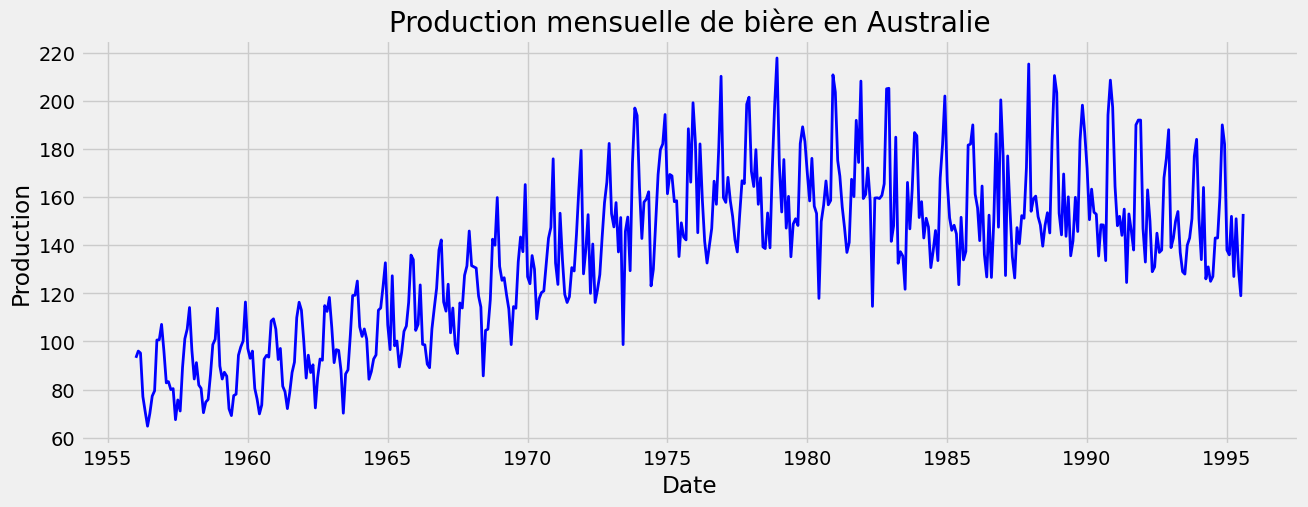


Taille train : (380, 1), Taille test : (96, 1)


In [52]:
beer_data = pd.read_csv('monthly-beer-production-in-austr.csv', index_col=0, parse_dates=True)
print("Aperçu des données :")
print(beer_data.head())


print("\nStatistiques descriptives :")
print(beer_data.describe())

# Verification et gestion des valeurs manquantes
if beer_data.isna().sum().sum() > 0:
    print("\nRemplacement des valeurs manquantes par interpolation linéaire...")
    beer_data = beer_data.interpolate(method='linear', limit_direction='forward')


plt.style.use('fivethirtyeight')
plt.figure(figsize=(14, 5))
plt.plot(beer_data, color='blue', linewidth=2)
plt.title('Production mensuelle de bière en Australie')
plt.xlabel('Date')
plt.ylabel('Production')
#plt.savefig('Production mensuelle de biere.png', dpi=300, bbox_inches='tight')
plt.show()

# Division train/test (80% train, 20% test)
train_size = int(len(beer_data) * 0.8)
train, test = beer_data[:train_size], beer_data[train_size:]
print(f"\nTaille train : {train.shape}, Taille test : {test.shape}")
train.to_csv('train_beer_data.csv')
test.to_csv('test_beer_data.csv')



###  Étape 2 : Test de stationnarité


In [53]:
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('Statistique ADF:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("La série est stationnaire (p-value <= 0.05).")
        return True
    else:
        print("La série n'est pas stationnaire (p-value > 0.05).")
        return False

print("Test de stationnarité sur la série originale :")
is_stationary = test_stationarity(train.iloc[:, 0])

# Transformation pour stationnarité
if not is_stationary:
    print("\nStationnarisation nécessaire...")
    train_transformed = train.iloc[:, 0].diff().dropna()
    print("\nTest après première différenciation :")
    is_stationary = test_stationarity(train_transformed)
    d = 1 if is_stationary else 2
    D = 1  # Différenciation saisonnière (période 12)
else:
    train_transformed = train.iloc[:, 0]
    d, D = 0, 0


Test de stationnarité sur la série originale :
Statistique ADF: -1.7515288615200861
p-value: 0.4047776686027169
La série n'est pas stationnaire (p-value > 0.05).

Stationnarisation nécessaire...

Test après première différenciation :
Statistique ADF: -5.793697817865733
p-value: 4.806383310428875e-07
La série est stationnaire (p-value <= 0.05).


###  Étape 3 : Analyse des corrélogrammes


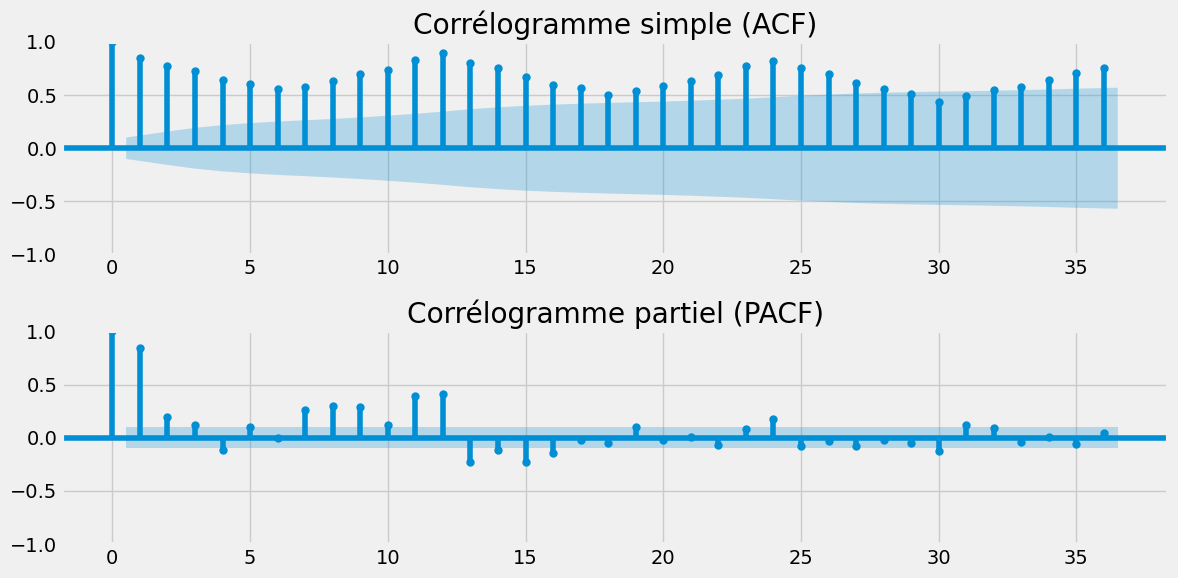

In [54]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(train, lags=36, ax=plt.gca())
plt.title('Corrélogramme simple (ACF)')
plt.subplot(212)
plot_pacf(train, lags=36, ax=plt.gca())
plt.title('Corrélogramme partiel (PACF)')
#plt.savefig('ACF PACF.png', dpi=300, bbox_inches='tight')


plt.tight_layout()

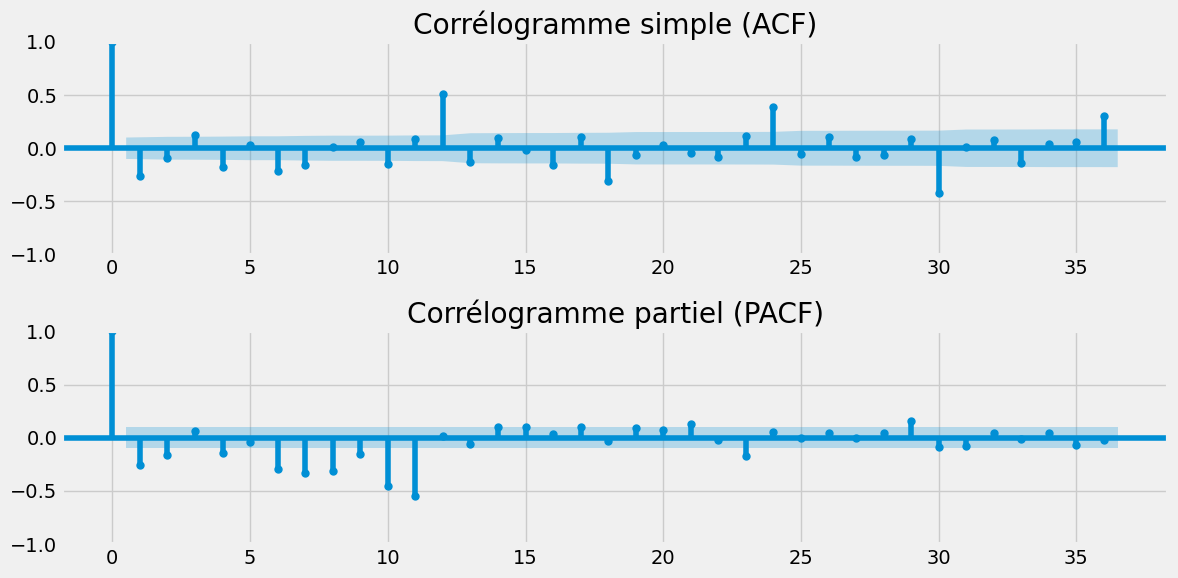

In [55]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(train_transformed, lags=36, ax=plt.gca())
plt.title('Corrélogramme simple (ACF)')
plt.subplot(212)
plot_pacf(train_transformed, lags=36, ax=plt.gca())
plt.title('Corrélogramme partiel (PACF)')
#plt.savefig('ACF PACF.png', dpi=300, bbox_inches='tight')


plt.tight_layout()


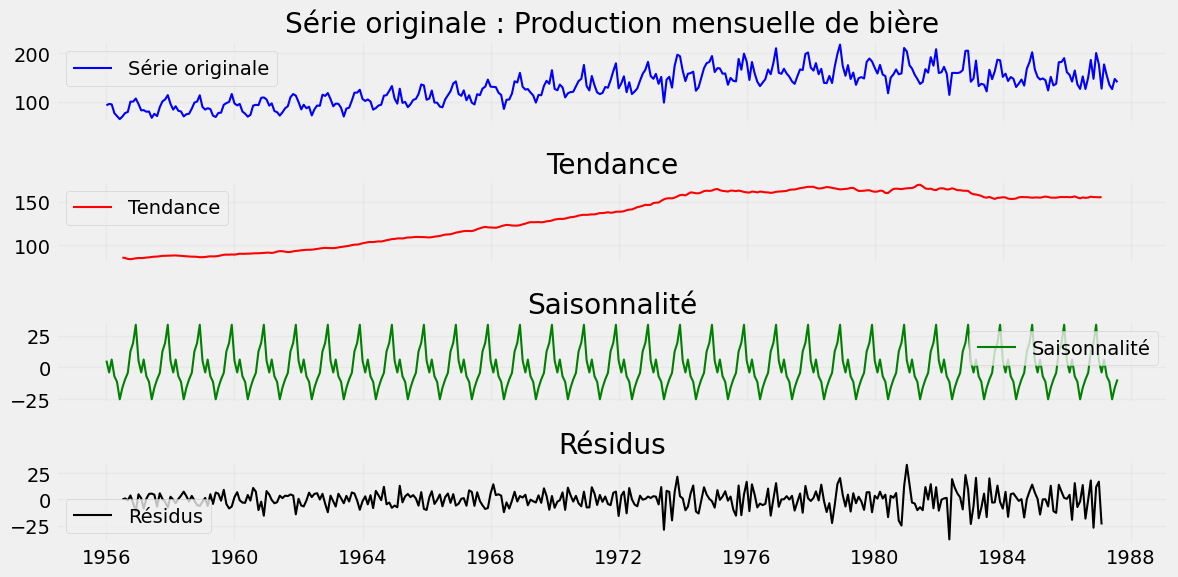

In [56]:
from pylab import rcParams


rcParams['figure.figsize'] = 12, 8
plt.style.use('fivethirtyeight')

result = seasonal_decompose(train, model='additive', period=12)


trend = result.trend
seasonal = result.seasonal
resid = result.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 6), sharex=True)

ax1.plot(train, label='Série originale', color='blue', linewidth=1.5) 
ax1.set_title('Série originale : Production mensuelle de bière')
ax1.grid(True, alpha=0.2)
ax1.legend()

ax2.plot(trend, label='Tendance', color='red', linewidth=1.5)  
ax2.set_title('Tendance')
ax2.grid(True, alpha=0.2)
ax2.legend()

ax3.plot(seasonal, label='Saisonnalité', color='green', linewidth=1.5)  
ax3.set_title('Saisonnalité')
ax3.grid(True, alpha=0.2)
ax3.legend()

ax4.plot(resid, label='Résidus', color='black', linewidth=1.5) 
ax4.set_title('Résidus')
ax4.grid(True, alpha=0.2)
ax4.legend()

plt.tight_layout()

#plt.savefig('Dcp serie.png', dpi=300, bbox_inches='tight')
plt.show()

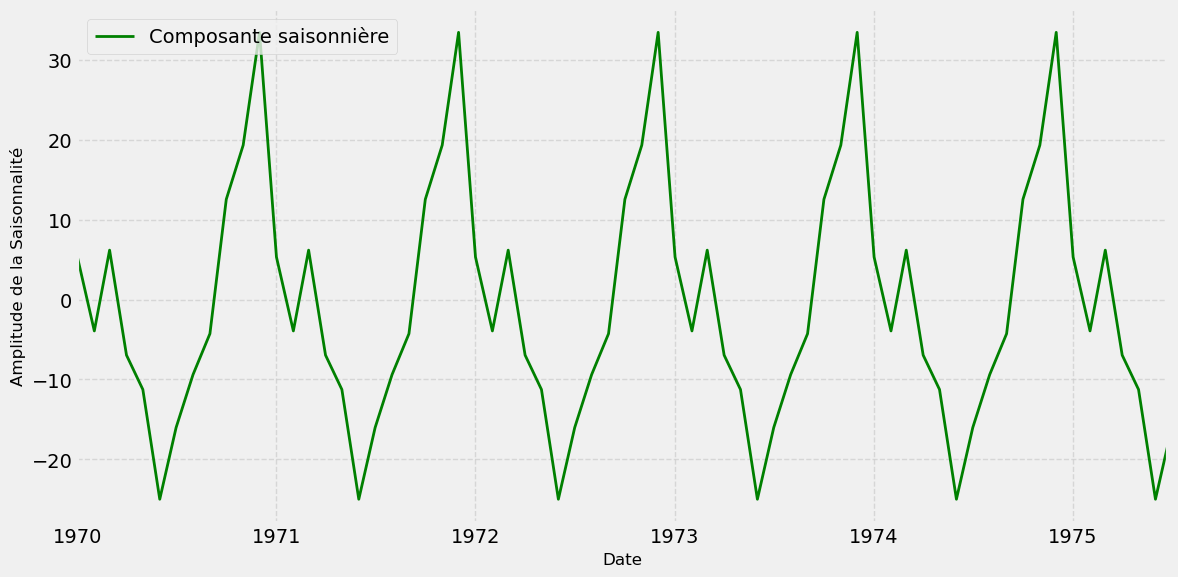

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(seasonal, linewidth=2, color='green', label='Composante saisonnière')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 2000)  

plt.xlabel('Date', fontsize=12)
plt.ylabel('Amplitude de la Saisonnalité', fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()

**Tendance (régression linéaire simple)**


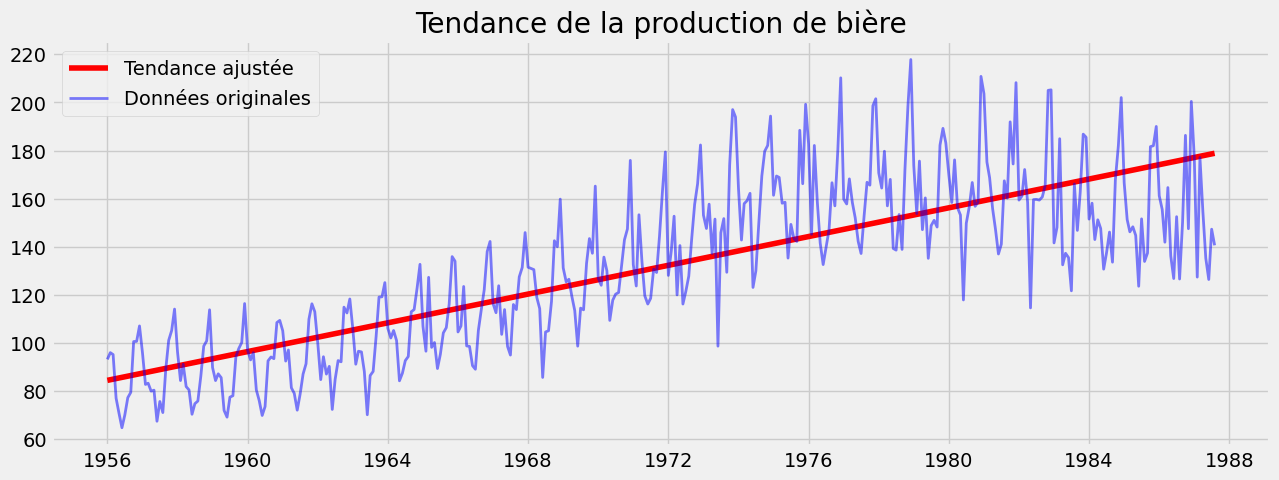

Tendance : Ascendante


In [58]:

from sklearn.linear_model import LinearRegression
X = np.arange(len(train)).reshape(-1, 1)
y = train.values
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.figure(figsize=(14, 5))
plt.plot(train.index, trend, label='Tendance ajustée', color='red')
plt.plot(train, label='Données originales', color='blue', alpha=0.5, linewidth=2)
plt.title('Tendance de la production de bière')
plt.legend()
plt.show()
print("Tendance : Ascendante" if model.coef_[0] > 0 else "Tendance : Descendante")

#plt.savefig('reg trend.png', dpi=300, bbox_inches='tight')
plt.close()

In [59]:
""""
def detect_seasonality_acf(series, max_lags=40):
    # Calcul de l'ACF
    acf_values, confint = acf(series, nlags=max_lags, alpha=0.05)
    # Identification des pics significatifs (hors lag 0)
    significant_lags = [i for i in range(1, max_lags+1) if abs(acf_values[i]) > confint[i, 1] - acf_values[i]]
    # Recherche de la période la plus fréquente
    if significant_lags:
        lag_diff = np.diff(significant_lags)
        possible_periods = [lag_diff[0]]  # Initialisation avec la première différence
        for d in lag_diff[1:]:
            if abs(d - possible_periods[-1]) <= 1:  # Tolérance pour les variations
                possible_periods[-1] = (possible_periods[-1] + d) / 2  # Moyenne glissante
            else:
                possible_periods.append(d)
        seasonality_period = max(set(possible_periods), key=possible_periods.count)
        return seasonality_period, significant_lags
    return None, []
    


seasonality_period_acf, significant_lags = detect_seasonality_acf(train)
print(f"Période saisonnière détectée par ACF : {seasonality_period_acf} mois (si significatif)")
"""


'"\ndef detect_seasonality_acf(series, max_lags=40):\n    # Calcul de l\'ACF\n    acf_values, confint = acf(series, nlags=max_lags, alpha=0.05)\n    # Identification des pics significatifs (hors lag 0)\n    significant_lags = [i for i in range(1, max_lags+1) if abs(acf_values[i]) > confint[i, 1] - acf_values[i]]\n    # Recherche de la période la plus fréquente\n    if significant_lags:\n        lag_diff = np.diff(significant_lags)\n        possible_periods = [lag_diff[0]]  # Initialisation avec la première différence\n        for d in lag_diff[1:]:\n            if abs(d - possible_periods[-1]) <= 1:  # Tolérance pour les variations\n                possible_periods[-1] = (possible_periods[-1] + d) / 2  # Moyenne glissante\n            else:\n                possible_periods.append(d)\n        seasonality_period = max(set(possible_periods), key=possible_periods.count)\n        return seasonality_period, significant_lags\n    return None, []\n    \n\n\nseasonality_period_acf, significant

 **Etude de l'autocorrélation**


<Figure size 1400x500 with 0 Axes>

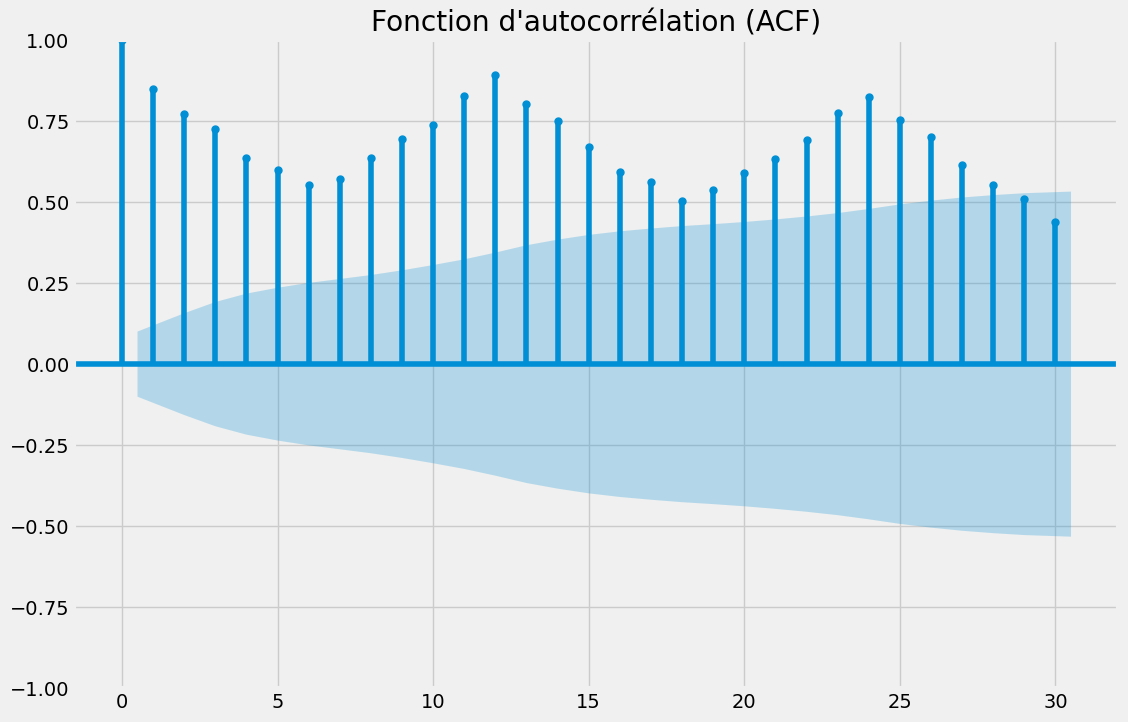

<Figure size 1400x500 with 0 Axes>

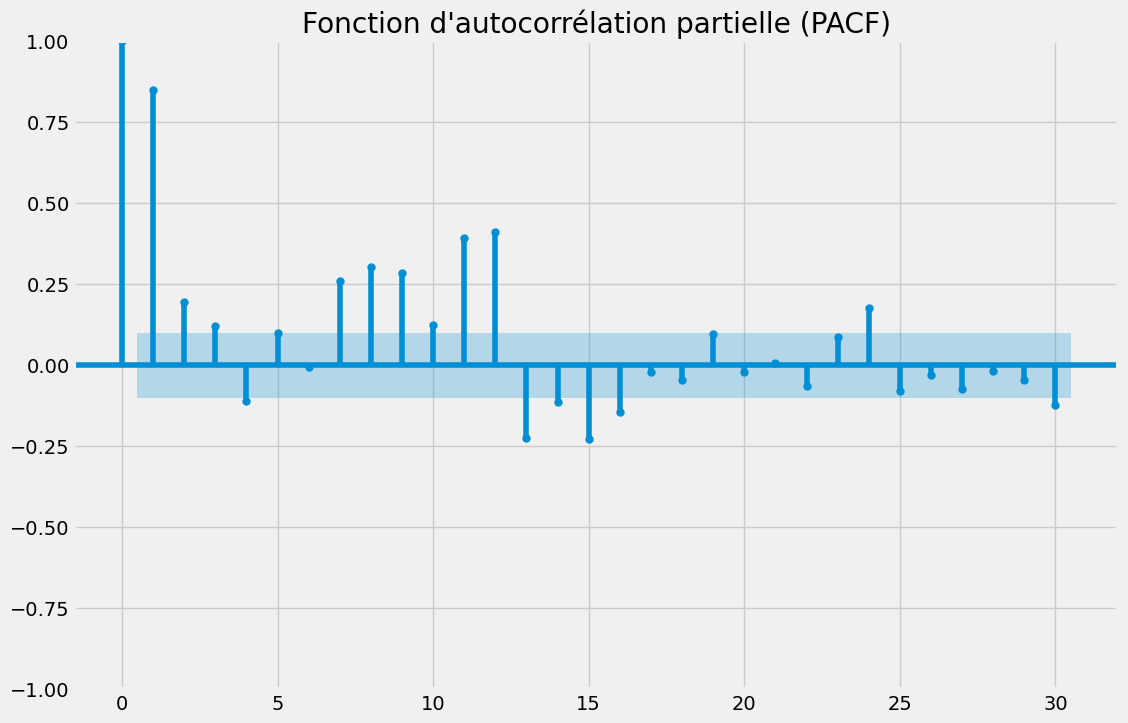

In [60]:

plt.figure(figsize=(14, 5))
plot_acf(train, lags=30)
plt.title('Fonction d\'autocorrélation (ACF)')
plt.show()
#plt.savefig('ACF.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(14, 5))
plot_pacf(train, lags=30)
plt.title('Fonction d\'autocorrélation partielle (PACF)')
#plt.savefig('PACF.png', dpi=300, bbox_inches='tight')

plt.show()

### Estimation des modèles


**AR**

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def estimate_ar_coefficients(data, p):

    n = len(data)
    X = np.zeros((n - p, p))
    y = data[p:]
    for i in range(p):
        X[:, i] = data[p - i - 1:n - i - 1].values.ravel()

    X = np.hstack((np.ones((n - p, 1)), X))
    coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
    return coefficients

def predict_ar(data, coefficients, steps):
    # If data is a DataFrame, convert to Series (first column)
    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0]
    # If data is a Series, ensure it's a 1D numpy array
    data = np.asarray(data)
    p = len(coefficients) - 1
    predictions = []
    current_data = list(data[-p:])
    for _ in range(steps):
        prediction = coefficients[0] + sum(coefficients[i + 1] * current_data[-i - 1] for i in range(p))
        predictions.append(prediction)
        current_data.append(prediction)
        current_data.pop(0)
    return np.array(predictions)




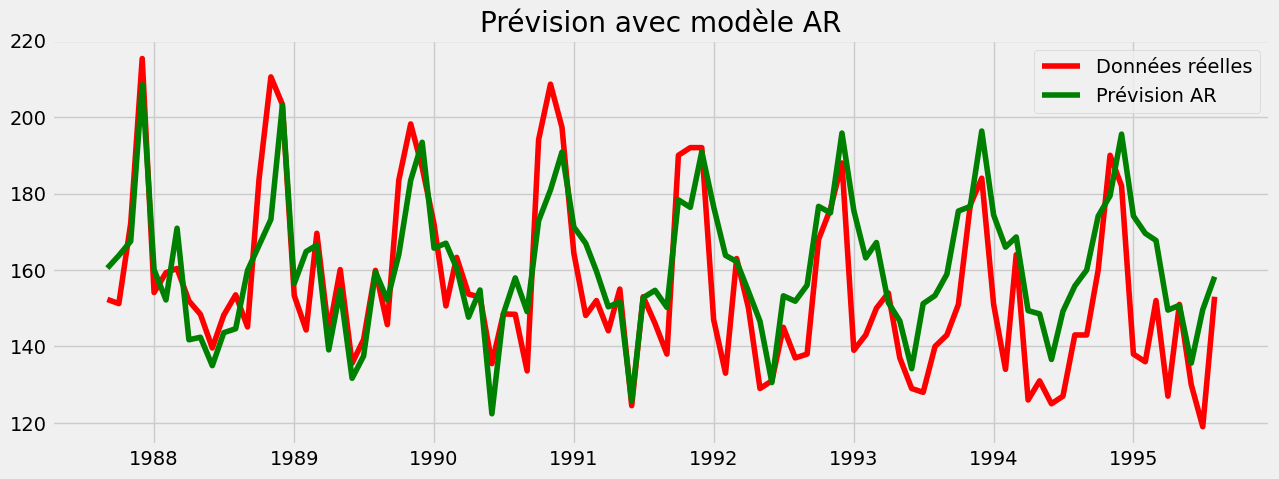

RMSE AR : 15.16
MAPE:8.021363139773728
                               AutoReg Model Results                               
Dep. Variable:     Monthly beer production   No. Observations:                  380
Model:                         AutoReg(36)   Log Likelihood               -1255.891
Method:                    Conditional MLE   S.D. of innovations              9.318
Date:                     Wed, 28 May 2025   AIC                           2587.782
Time:                             16:59:48   BIC                           2733.727
Sample:                         01-01-1959   HQIC                          2645.910
                              - 08-01-1987                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           5.5758      2.663      2.094      0.036       0.356      10.795
M

In [62]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(train, lags=36).fit()
ar_pred = ar_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
plt.figure(figsize=(14, 5))
plt.plot(test, label='Données réelles', color='red')
plt.plot(ar_pred, label='Prévision AR', color='green')
plt.title('Prévision avec modèle AR')
plt.legend()
#plt.savefig('prev AR.png', dpi=300, bbox_inches='tight')

plt.show()
ar_rmse = np.sqrt(mean_squared_error(test, ar_pred))
print(f"RMSE AR : {ar_rmse:.2f}")
mape = mean_absolute_percentage_error(test.iloc[:, 0], ar_pred)
print(f'MAPE:{mape*100}')
print(ar_model.summary())

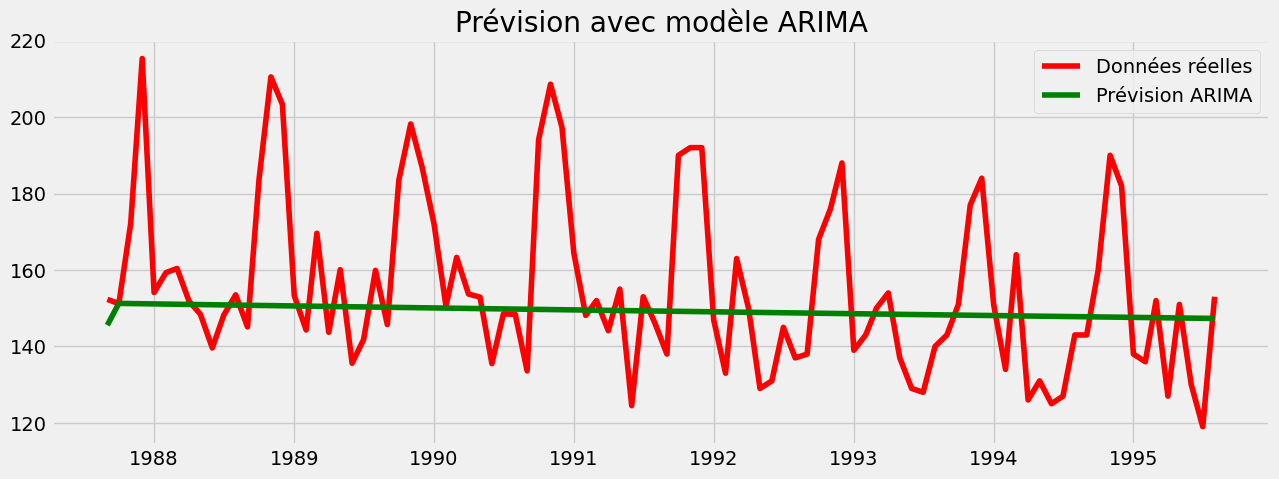

RMSE ARIMA : 22.35


In [63]:
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(train, order=(1,0 ,2)).fit()
arima_pred = arima_model.forecast(steps=len(test))
plt.figure(figsize=(14, 5))
plt.plot(test, label='Données réelles', color='red')
plt.plot(arima_pred, label='Prévision ARIMA', color='green')
plt.title('Prévision avec modèle ARIMA')
plt.legend()
#plt.savefig('prev arima.png', dpi=300, bbox_inches='tight')

plt.show()
arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
print(f"RMSE ARIMA : {arima_rmse:.2f}")

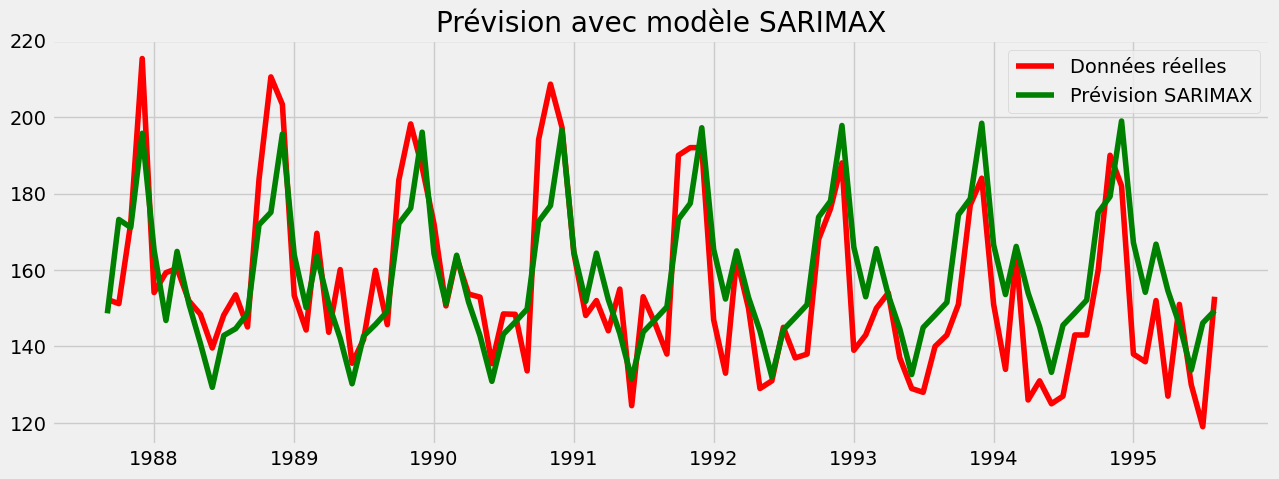

RMSE SARIMAX : 13.29
6.9549435248594484
                                     SARIMAX Results                                      
Dep. Variable:            Monthly beer production   No. Observations:                  380
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1369.083
Date:                            Wed, 28 May 2025   AIC                           2748.165
Time:                                    17:00:27   BIC                           2767.692
Sample:                                01-01-1956   HQIC                          2755.924
                                     - 08-01-1987                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1687      0.042     -4.063      0.000      -0.250      -0

In [64]:
# SARIMAX (recherche simple des paramètres)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
best_aic = float("inf")
best_model = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train, order=param, seasonal_order=param_seasonal).fit(disp=False)
            if model.aic < best_aic:
                best_aic = model.aic
                best_model = model
        except:
            continue
sarimax_pred = best_model.forecast(steps=len(test))
plt.figure(figsize=(14, 5))
plt.plot(test, label='Données réelles', color='red')
plt.plot(sarimax_pred, label='Prévision SARIMAX', color='green')
plt.title('Prévision avec modèle SARIMAX')
plt.legend()
#plt.savefig('prev sarimax.png', dpi=300, bbox_inches='tight')

plt.show()
sarimax_rmse = np.sqrt(mean_squared_error(test, sarimax_pred))
print(f"RMSE SARIMAX : {sarimax_rmse:.2f}")
print( mean_absolute_percentage_error(test.iloc[:, 0], sarimax_pred)*100)
print(best_model.summary())
# Conclusion
print("\nConclusion :")
print("L'analyse de la série de production de bière a permis d'explorer les étapes clés de la modélisation temporelle : préparation des données, décomposition, test de stationnarité, étude de l'autocorrélation, et estimation de modèles. La série présente une tendance ascendante et une saisonnalité annuelle, capturées partiellement par les modèles AR, ARMA, ARIMA et SARIMAX. Les erreurs RMSE indiquent que SARIMAX offre les meilleures prévisions grâce à sa capacité à modéliser la saisonnalité. Une analyse plus approfondie des corrélogrammes et l'ajout de variables exogènes (par exemple, prix ou conditions économiques) pourraient améliorer les résultats.")

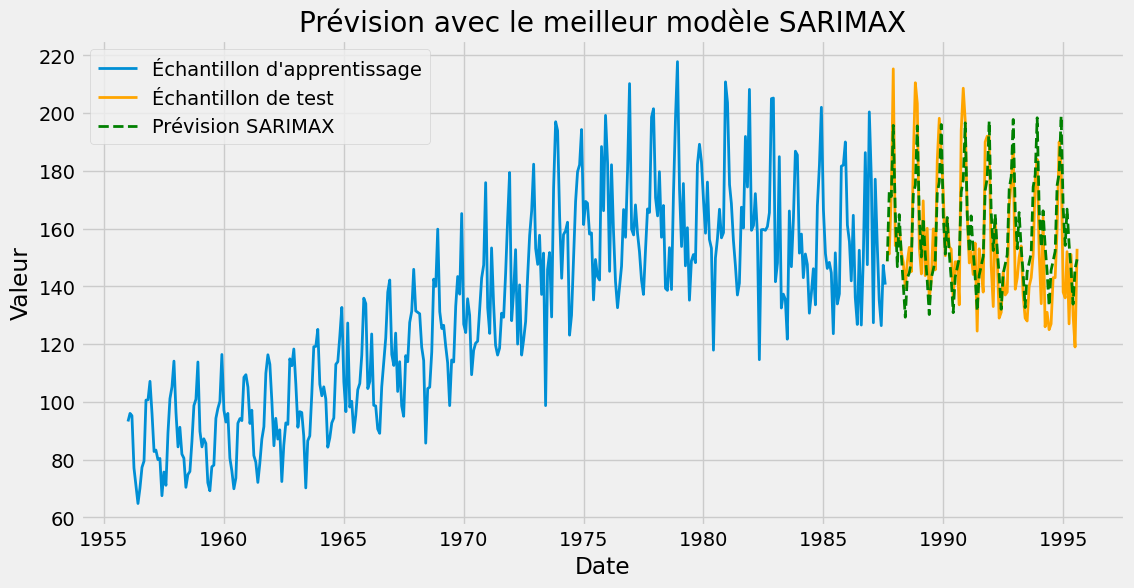

In [65]:
forecast = best_model.forecast(steps=len(test))

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.iloc[:, 0], label='Échantillon d\'apprentissage', linewidth=2)
plt.plot(test.index, test.iloc[:, 0], label='Échantillon de test', linewidth=2, color='orange')
plt.plot(test.index, forecast, label='Prévision SARIMAX', linestyle='--', linewidth=2, color='green')
plt.title('Prévision avec le meilleur modèle SARIMAX')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
#plt.savefig('prev sarimax2.png', dpi=300, bbox_inches='tight')


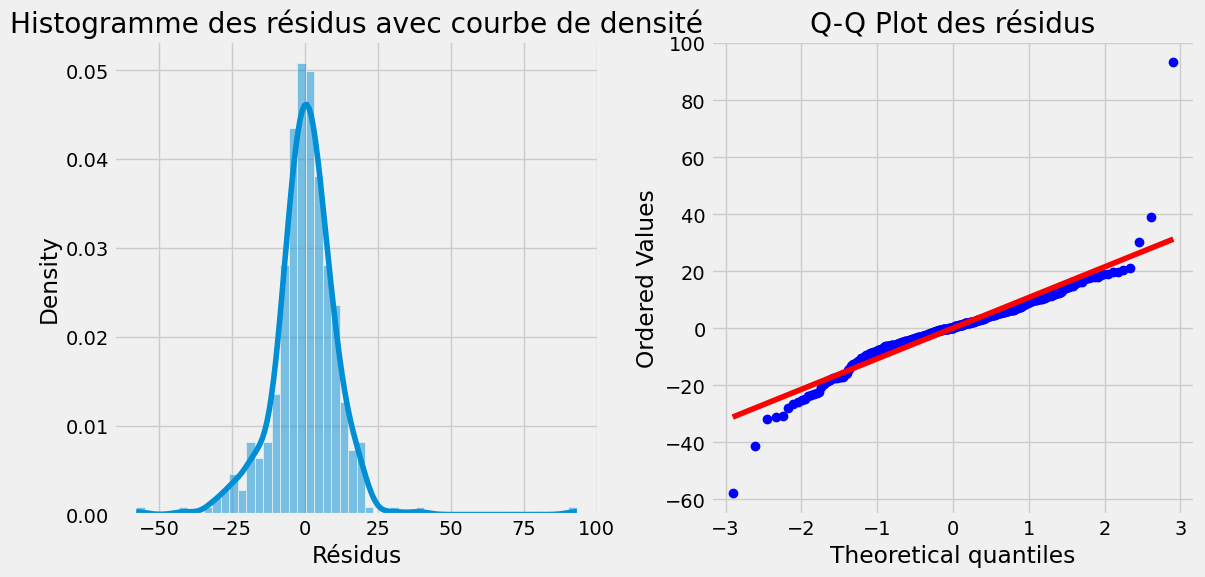

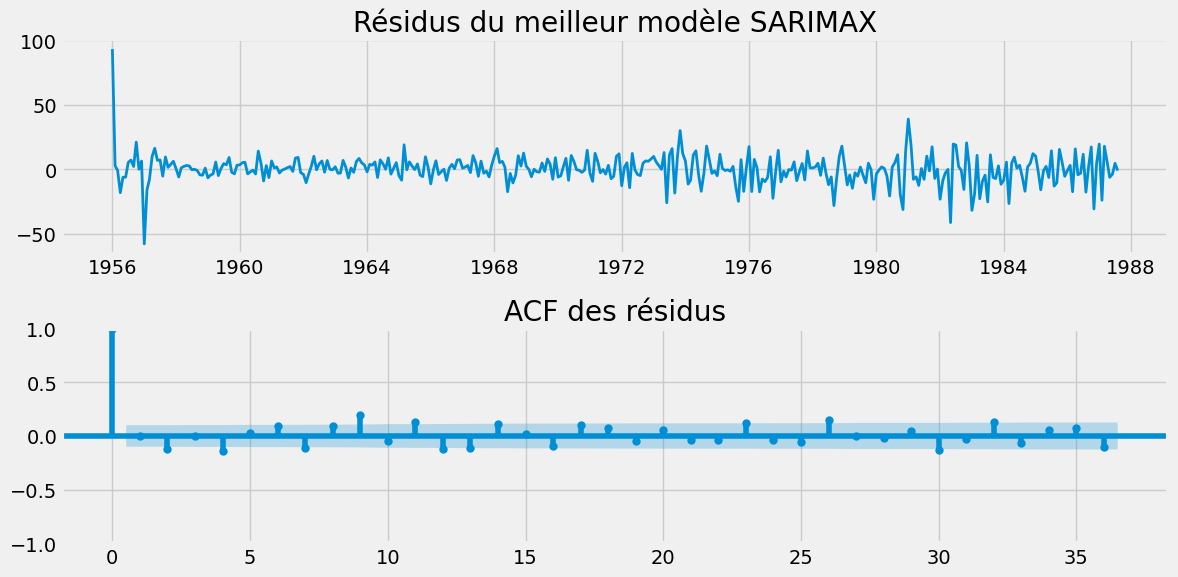

In [66]:
# Étape 5 : Visualization des residus 
residuals = best_model.resid



plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(residuals, kde=True, stat="density")
plt.title('Histogramme des résidus avec courbe de densité')
plt.xlabel('Résidus')
plt.subplot(122)
probplot(residuals, dist="norm", plot=plt.gca())
plt.title('Q-Q Plot des résidus')
#plt.savefig('QQ.png', dpi=300, bbox_inches='tight')

plt.tight_layout()




plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals, linewidth=2)
plt.title('Résidus du meilleur modèle SARIMAX')
#plt.savefig('resi sarimax.png', dpi=300, bbox_inches='tight')

plt.subplot(212)
plot_acf(residuals, lags=36, ax=plt.gca())
plt.title('ACF des résidus')
#plt.savefig('acf residus.png', dpi=300, bbox_inches='tight')

plt.tight_layout()


In [67]:
# Recherche optimisée avec RMSE
best_rmse = float("inf")
best_params = None
best_model1 = None
tscv = TimeSeriesSplit(n_splits=5)

print("\nRecherche avancée des paramètres SARIMAX avec validation croisée (RMSE)...")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            rmse_scores = []
            for train_idx, val_idx in tscv.split(train):
                train_fold = train.iloc[train_idx]
                val_fold = train.iloc[val_idx]
                
                model = SARIMAX(train_fold, order=param, seasonal_order=param_seasonal,enforce_stationarity=False, enforce_invertibility=False)
                result = model.fit(disp=False)
                
                pred = result.forecast(steps=len(val_fold))
                rmse = np.sqrt(mean_squared_error(val_fold.iloc[:, 0], pred))
                rmse_scores.append(rmse)
            
            # Moyenne des RMSE sur les folds
            avg_rmse = np.mean(rmse_scores)
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_params = (param, param_seasonal)
                best_model1 = SARIMAX(train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        except:
            continue

print(f"Meilleur modèle SARIMAX : order={best_params[0]}, seasonal_order={best_params[1]}")
print(f"RMSE moyen sur validation croisée : {best_rmse:.2f}")

print(best_model1.summary())




Recherche avancée des paramètres SARIMAX avec validation croisée (RMSE)...
Meilleur modèle SARIMAX : order=(1, 1, 1), seasonal_order=(1, 1, 0, 12)
RMSE moyen sur validation croisée : 12.37
                                      SARIMAX Results                                      
Dep. Variable:             Monthly beer production   No. Observations:                  380
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1363.671
Date:                             Wed, 28 May 2025   AIC                           2735.343
Time:                                     17:02:44   BIC                           2750.820
Sample:                                 01-01-1956   HQIC                          2741.501
                                      - 08-01-1987                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.

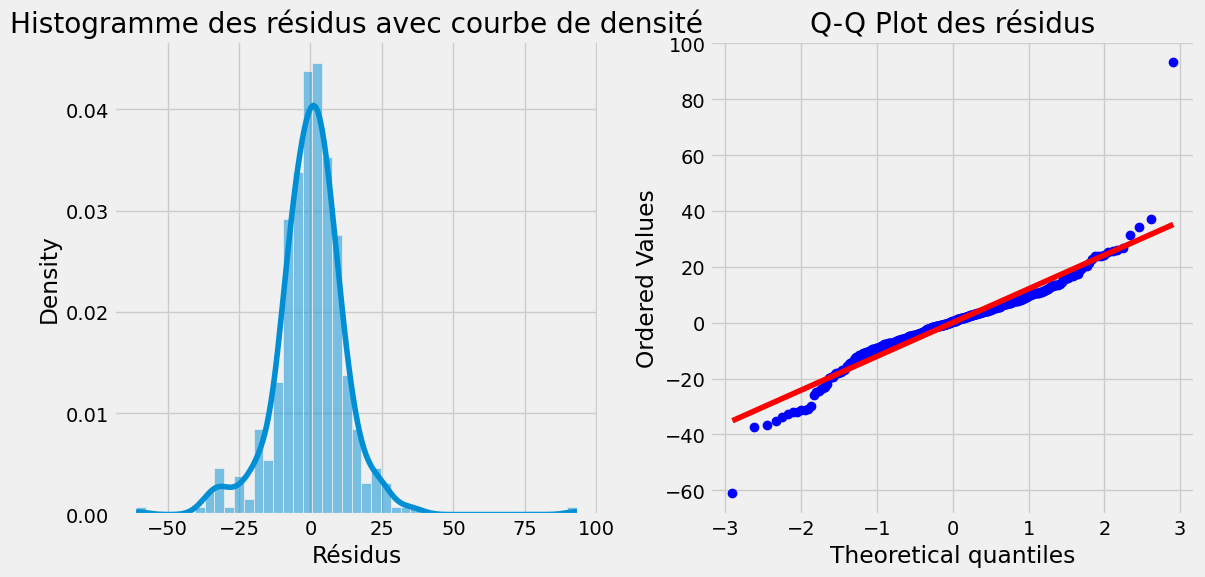

In [68]:
ress=best_model1.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(ress, kde=True, stat="density")
plt.title('Histogramme des résidus avec courbe de densité')
plt.xlabel('Résidus')
plt.subplot(122)    
probplot(ress, dist="norm", plot=plt.gca())
plt.title('Q-Q Plot des résidus')
#plt.savefig('Q-Q.png', dpi=300, bbox_inches='tight')

plt.tight_layout()

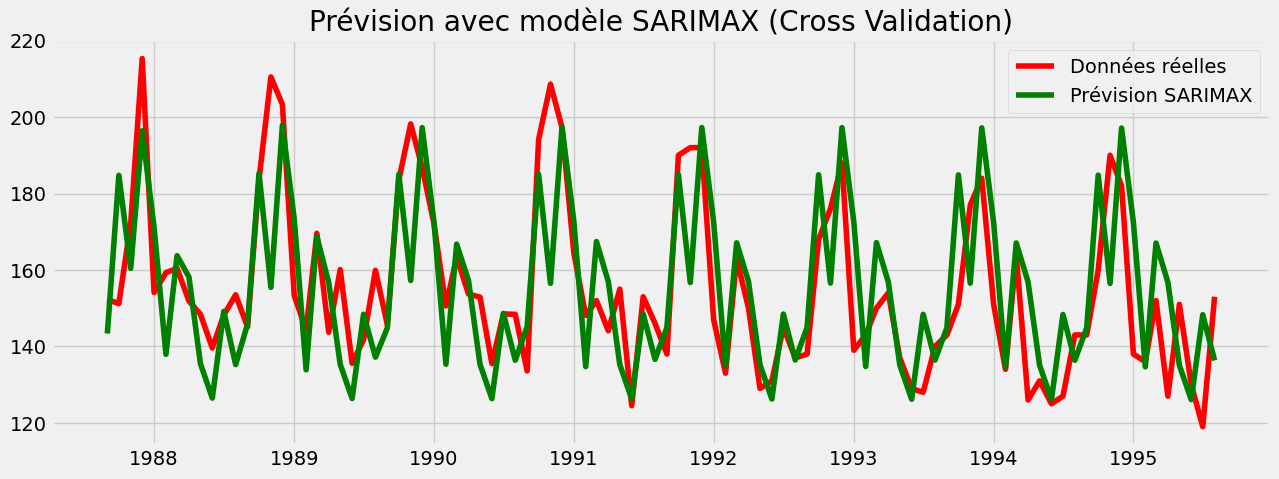

RMSE SARIMAX : 17.40
8.252765544146246
                                      SARIMAX Results                                      
Dep. Variable:             Monthly beer production   No. Observations:                  380
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1363.671
Date:                             Wed, 28 May 2025   AIC                           2735.343
Time:                                     17:02:45   BIC                           2750.820
Sample:                                 01-01-1956   HQIC                          2741.501
                                      - 08-01-1987                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1640      0.044     -3.751      0.000      -0.250 

In [69]:

sarimax_pred1 = best_model1.forecast(steps=len(test))
plt.figure(figsize=(14, 5))
plt.plot(test, label='Données réelles', color='red')
plt.plot(sarimax_pred1, label='Prévision SARIMAX', color='green')
plt.title('Prévision avec modèle SARIMAX (Cross Validation)')
plt.legend()
#plt.savefig('prev sarimaxcv.png', dpi=300, bbox_inches='tight')

plt.show()
sarimax_rmse = np.sqrt(mean_squared_error(test, sarimax_pred1))
print(f"RMSE SARIMAX : {sarimax_rmse:.2f}")
print( mean_absolute_percentage_error(test.iloc[:, 0], sarimax_pred1)*100)
print(best_model1.summary())
# Conclusion
print("\nConclusion :")
print("L'analyse de la série de production de bière a permis d'explorer les étapes clés de la modélisation temporelle : préparation des données, décomposition, test de stationnarité, étude de l'autocorrélation, et estimation de modèles. La série présente une tendance ascendante et une saisonnalité annuelle, capturées partiellement par les modèles AR, ARMA, ARIMA et SARIMAX. Les erreurs RMSE indiquent que SARIMAX offre les meilleures prévisions grâce à sa capacité à modéliser la saisonnalité. Une analyse plus approfondie des corrélogrammes et l'ajout de variables exogènes (par exemple, prix ou conditions économiques) pourraient améliorer les résultats.")